<a href="https://colab.research.google.com/github/MustafaBozkurt84/predictive-maintanance-LSTM/blob/master/MultivariateTimeSeriesLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0
from matplotlib import pyplot
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
import pickle
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error
##################################
# Data Ingestion
##################################

# read training data - It is the aircraft engine run-to-failure data.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
df =pd.read_csv("/content/drive/MyDrive/Datasets/predictive maintance /31_hidrolikmotoru_analiz.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [40]:
df.head()

,name,time,partno,vibx,vibz,spm,temp,zacc,zfreq,xkurt,crestfactor,balancerbasinci
0,sensorvib31,2020-01-01T00:00:01.70401Z,NaN,0.18,0.11,NaN,15.75,0.04,0.01,2.94,3.6,NaN
1,sensorvib31,2020-01-01T00:00:03.70467Z,NaN,0.18,0.11,NaN,15.75,0.04,0.01,2.94,3.6,NaN
2,sensorvib31,2020-01-01T00:00:05.70553Z,NaN,0.18,0.15,NaN,15.75,0.04,0.01,2.97,4.2,NaN
3,sensorvib31,2020-01-01T00:00:07.7093Z,NaN,0.16,0.15,NaN,15.75,0.05,0.01,3.11,4.5,NaN
4,sensorvib31,2020-01-01T00:00:09.70685Z,NaN,0.16,0.15,NaN,15.75,0.05,0.01,3.11,4.5,NaN


In [41]:

df.drop(["name","partno","balancerbasinci","spm","xkurt"],axis=1,inplace=True)
df.columns=['Time', 'vibx', 'vibz', 'temp', 'zacc', 'zfreq', 'crest']
df["Time"]= [str(i).replace("2020-02-02","2/2/2020").replace("2020-01-02","2/1/2020") for i in df["Time"]]

df['Time'] = pd.to_datetime(df['Time']) 
df['Time']=[str(i).split(":")[0] for i in df["Time"]]
df['Time'] = pd.to_datetime(df['Time'],format="%Y-%m-%d %H") #%Y-%m-%d %H:%M:%S

df=df.groupby("Time").mean()
df.reset_index(inplace=True)
df.to_csv("/content/drive/MyDrive/Datasets/predictive maintance /DataAnaliz.csv")
df.head()

,Time,vibx,vibz,temp,zacc,zfreq,crest
0,2020-01-01 00:00:00,0.154338,0.144321,15.637208,0.041157,0.01,4.111596
1,2020-01-01 01:00:00,0.156064,0.145520,15.373346,0.041440,0.01,4.160439
2,2020-01-01 02:00:00,0.155957,0.146585,15.122024,0.041997,0.01,4.212914
3,2020-01-01 03:00:00,0.155334,0.143598,14.902892,0.043065,0.01,4.331691
4,2020-01-01 04:00:00,0.157375,0.144605,14.703281,0.047041,0.01,4.693571


In [42]:
data=df.copy()

In [43]:
ariza_tarihleri=["2020-01-27 00:00:00","2020-09-11 00:00:00","2020-10-06 00:00:00","2020-10-10 00:00:00","2020-10-13 00:00:00","2020-10-18 00:00:00","2020-10-30 00:00:00","2020-11-02 00:00:00"]
ariza_index = []
for i in ariza_tarihleri:
  ariza_index.append(df[df["Time"]==i].index[0])

In [44]:
ariza_index

[598, 5251, 5848, 5944, 5982, 6100, 6378, 6447]

In [45]:
drop_index_list=[]
for a in ariza_index:

  for i in range(0,24*5):
    drop_index_list.append(a+i)
  for i in range(0,24*2):
    drop_index_list.append(a-i)


In [46]:
df.drop(index=drop_index_list,axis=0,inplace=True)

In [47]:
df.reset_index(drop=True,inplace=True)

In [48]:
#df = pd.read_excel("/content/drive/MyDrive/Datasets/predictive maintance /AnalizDataPM.xlsx",engine='openpyxl')
#df["Time"]= [str(i).replace("2020-02-02","2/2/2020").replace("2020-01-02","2/1/2020") for i in df["Time"]]
#df['Time'] = pd.to_datetime(df['Time']) 
#df['Time']=[str(i).split(":")[0] for i in df["Time"]]
#df['Time'] = pd.to_datetime(df['Time'],format="%Y-%m-%d %H") #%Y-%m-%d %H:%M:%S
#df=df.groupby("Time").mean()
#df.reset_index(inplace=True)
#df.to_csv("/content/drive/MyDrive/Datasets/predictive maintance /DataAnaliz.csv")
#df.head()

In [49]:
fail_time =df[df["Time"]=="2020-01-27 14:00:00"].index[0]

IndexError: ignored

In [50]:
 def feature_engineering(df):
  df['Hour'] = df['Time'].apply(lambda time: time.hour)
  df['Month'] = df['Time'].apply(lambda time: time.month)
  df['Day of Week'] = df['Time'].apply(lambda time: time.dayofweek)
  df['Year'] = df['Time'].apply(lambda t: t.year)
  df=pd.get_dummies(df,columns=['Hour','Month','Day of Week','Year'],drop_first=True)
  for col in df.columns[1:7]:
    for i in range(1,4):
      df['lag_'+str(i)+col] = df[col].shift(i)
  for col in df.columns[1:7]:
    df[col+'expanding_mean'] = df[col].expanding(5).mean()
    df[col+'expanding_std'] = df[col].expanding(5).std()
  df.dropna(axis=0,inplace=True)
  return df
data =feature_engineering(data)

In [51]:
df['Hour'] = df['Time'].apply(lambda time: time.hour)
df['Month'] = df['Time'].apply(lambda time: time.month)
df['Day of Week'] = df['Time'].apply(lambda time: time.dayofweek)
df['Year'] = df['Time'].apply(lambda t: t.year)
df=pd.get_dummies(df,columns=['Hour','Month','Day of Week','Year'],drop_first=True)



In [52]:
for col in df.columns[1:7]:
  for i in range(1,4):
      df['lag_'+str(i)+col] = df[col].shift(i)


In [53]:
for col in df.columns[1:7]:
  df[col+'expanding_mean'] = df[col].expanding(5).mean()
  df[col+'expanding_std'] = df[col].expanding(5).std()
df.dropna(axis=0,inplace=True)

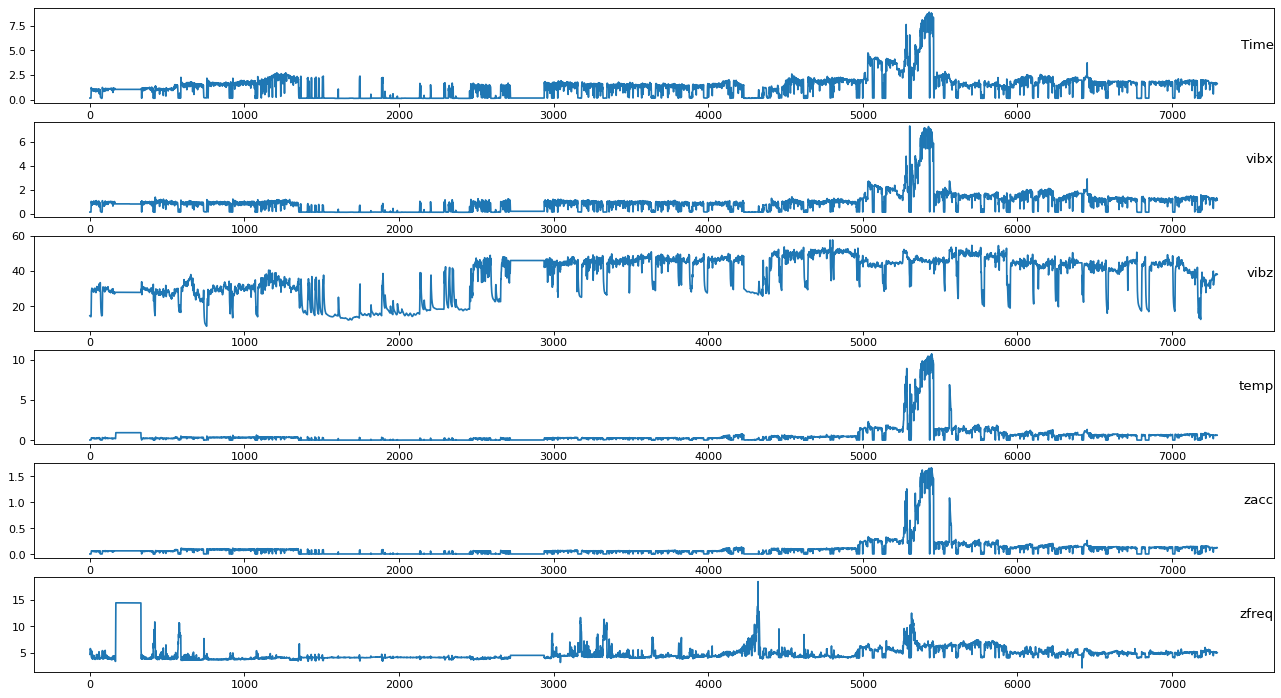

In [54]:
values = df.iloc[:,1:].values
# specify columns to plot
groups = [0,1, 2, 3, 4,5]
i = 1
# plot each column
pyplot.figure(figsize=(20, 11), dpi=80)
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(df.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [55]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [56]:
def pickle_all(key,value):
         pickle_out = open(key, "wb")
         pickle.dump(value, pickle_out)
         pickle_out.close()


In [57]:
 def multivariae_lstm(col_num):
    values = df.iloc[:,1:].values
    # integer encode direction
    #encoder = LabelEncoder()
    #values[:,4] = encoder.fit_transform(values[:,4])
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    pickle_all(f"/content/drive/MyDrive/model_predictive_maintanence/{df.columns[col_num+1]}_scaler_lstm_multivariate.pkl",scaler)
    #scaled=values
    # specify the number of lag hours
    test=data.iloc[:,1:].values
    test = test.astype('float32')
    scaled_test=scaler.transform(test)
    n_hours = 10
    n_features = df.iloc[:,1:].shape[1]
    # frame as supervised learning
    reframed = series_to_supervised(scaled, n_hours, 1)
    test_reframed=series_to_supervised(scaled_test, n_hours, 1)
    #print(reframed.shape)
    
    # split into train and test sets
    values = reframed.values
    n_train_hours = 7000
    #train = values[:n_train_hours, :]
    train = values

    test = test_reframed.values
    # split into input and outputs
    n_obs = n_hours * n_features
    train_X, train_y = train[:, :n_obs], train[:, col_num]
    test_X, test_y = test[:, :n_obs], test[:, col_num]
    #print(train_X.shape, len(train_X), train_y.shape)
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
    #print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    history = model.fit(train_X, train_y, epochs=200, batch_size=10, validation_data=(test_X, test_y), verbose=1, shuffle=False)
    # make a prediction
    model.save(f"/content/drive/MyDrive/model_predictive_maintanence/{df.columns[col_num+1]}multivariateLSTM_model.h5")
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
    # plot history
    
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
        
    # invert scaling for forecast

    inv_yhat1 = np.repeat(yhat, df.shape[1]-1, axis=-1)
    inv_yhat1 = scaler.inverse_transform(inv_yhat1)
    inv_yhat1 = inv_yhat1[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))

    inv_y = np.repeat(test_y, df.shape[1]-1, axis=-1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat1))
    print('Test RMSE: %.3f' % rmse)
    pyplot.figure(figsize=(12, 8), dpi=80)
    pyplot.plot(inv_y,label=df.columns[col_num+1])
    pyplot.plot(inv_yhat1,label=df.columns[col_num+1]+"_predicted")
    pyplot.title(df.columns[col_num+1]+" multivariate LSTM")
    pyplot.legend()
    pyplot.show()

In [ ]:
multivariae_lstm(0)

Epoch 1/200
729/729 [==============================] - 5s 5ms/step - loss: 0.0647 - val_loss: 0.0875
Epoch 2/200
729/729 [==============================] - 4s 5ms/step - loss: 0.0436 - val_loss: 0.0857
Epoch 3/200
729/729 [==============================] - 4s 5ms/step - loss: 0.0405 - val_loss: 0.0816
Epoch 4/200
729/729 [==============================] - 4s 5ms/step - loss: 0.0412 - val_loss: 0.1065
Epoch 5/200
729/729 [==============================] - 4s 5ms/step - loss: 0.0365 - val_loss: 0.0626
Epoch 6/200
729/729 [==============================] - 4s 5ms/step - loss: 0.0300 - val_loss: 0.0737
Epoch 7/200
729/729 [==============================] - 4s 5ms/step - loss: 0.0295 - val_loss: 0.0596
Epoch 8/200
729/729 [==============================] - 4s 5ms/step - loss: 0.0282 - val_loss: 0.0631
Epoch 9/200
729/729 [==============================] - 4s 5ms/step - loss: 0.0269 - val_loss: 0.0520
Epoch 10/200
729/729 [==============================] - 4s 5ms/step - loss: 0.0256 - val_lo

In [ ]:
multivariae_lstm(1)

In [ ]:
multivariae_lstm(2)

In [ ]:
multivariae_lstm(3)

In [ ]:
multivariae_lstm(4)

In [ ]:
multivariae_lstm(5)

In [ ]:
multivariae_lstm(65)

In [ ]:
multivariae_lstm(64)

In [ ]:
multivariae_lstm(63)

In [ ]:
multivariae_lstm(62)

In [ ]:
multivariae_lstm(61)

In [ ]:
multivariae_lstm(60)

In [ ]:
multivariae_lstm(59)

In [ ]:
multivariae_lstm(58)

In [ ]:
multivariae_lstm(57)

In [ ]:
multivariae_lstm(56)

In [ ]:
multivariae_lstm(55)

In [ ]:
multivariae_lstm(54)